In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers.convolutional import Conv1D 
from keras.layers import LSTM 

In [2]:
reviews = pd.read_csv("df_allCurrentDataBalanced.csv")
#new_reviews = reviews.drop(labels = ["First_Name", "Last_Name", "Age"], axis = 1)
final_rev = reviews.dropna(axis=0, subset=['review'])
final_rev.head()

,Unnamed: 0,rating,title,review
0,1.0,good,ģhncjc xhxn vuhrcb,ek het baie gooi diens gekry van 1-grid ondvang
1,2.0,bad,1-Grid has become very difficult to work with,Scary! Bad! Frustrating with regards to billin...
2,3.0,good,Email problems sorted,"Very good service from Akhona, effecient and f..."
3,4.0,good,Fantastic!,I am quite happy with the service i received t...
4,5.0,bad,Without words about the Service,"Like the subject says, I really don't know wha..."


In [3]:
final_rev.rating.value_counts()

very bad     45841
bad          45816
very good    37325
good         37325
neutral       1377
Name: rating, dtype: int64

<AxesSubplot:xlabel='rating', ylabel='count'>

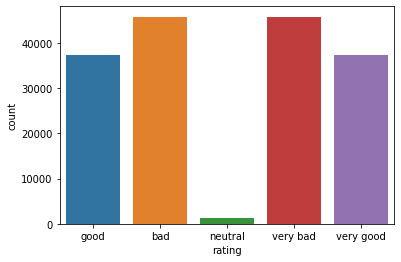

In [4]:
import seaborn as sns

sns.countplot(x='rating', data=final_rev)

In [5]:
def preprocess_text(sen):
    
    # Removing html tags
    sentence = str(remove_tags(sen))
    # Remove punctuations and numbers

    sentence = str(re.sub('[^a-zA-Z]', ' ', sentence))
    

    # Single character removal
    sentence = str(re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence))

    # Removing multiple spaces
    sentence = str(re.sub(r'\s+', ' ', sentence))

    sentence = str(sentence.lower())


    return sentence

In [6]:
TAG_RE = re.compile(r'<[^>]+>') ##

def remove_tags(text):
    return TAG_RE.sub('', text)

In [7]:
X = []
sentences = list(final_rev['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [8]:
X[111543]

'i would like to give very positive review to king price and nicky clark she has helped me from the start to the end even when had questions after hours and during lockdown with my claim she was always courteous friendly helpful and very professional kudo to you nicky would recommend you to anyone anytime you are the best thanks very much '

In [8]:
Y = pd.get_dummies(final_rev['rating']).values
print(Y)

[[0 1 0 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [10]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [11]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('C:\Python\Sentiment\.vector_cache\glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [12]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [13]:
## LSTM layer

from keras.models import Input
from keras.models import Model
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(5, activation='softmax')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          8823700   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 8,941,593
Trainable params: 117,893
Non-trainable params: 8,823,700
_________________________________________________________________
None


In [16]:
## Bidirectional model

from keras.models import Input
from keras.models import Model
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
model2 = Sequential()
model2.add(layers.Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False))
model2.add(layers.Bidirectional(layers.LSTM(128,dropout=0.6)))
model2.add(layers.Dense(5,activation='softmax'))
model2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
#checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, batch_size=128, epochs=25, verbose=1, validation_split=0.2)

Epoch 1/25
839/839 [==============================] - 1043s 1s/step - loss: 1.0014 - accuracy: 0.4888 - val_loss: 0.7785 - val_accuracy: 0.6033
Epoch 2/25
839/839 [==============================] - 993s 1s/step - loss: 0.8082 - accuracy: 0.5941 - val_loss: 0.7251 - val_accuracy: 0.6348
Epoch 3/25
839/839 [==============================] - 1015s 1s/step - loss: 0.7631 - accuracy: 0.6269 - val_loss: 0.7070 - val_accuracy: 0.6400
Epoch 4/25
839/839 [==============================] - 1017s 1s/step - loss: 0.7394 - accuracy: 0.6426 - val_loss: 0.6849 - val_accuracy: 0.6638
Epoch 5/25
839/839 [==============================] - 1029s 1s/step - loss: 0.7187 - accuracy: 0.6533 - val_loss: 0.6596 - val_accuracy: 0.6902
Epoch 6/25
839/839 [==============================] - 1058s 1s/step - loss: 0.7048 - accuracy: 0.6587 - val_loss: 0.6673 - val_accuracy: 0.6772
Epoch 7/25
839/839 [==============================] - 1035s 1s/step - loss: 0.6921 - accuracy: 0.6699 - val_loss: 0.6761 - val_accuracy: 

KeyboardInterrupt: 

In [14]:
history = model.fit(X_train, y_train, batch_size=128, epochs=25, verbose=1, validation_split=0.2)

Epoch 1/25


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [128,5] and labels shape [640]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-14-7aa1950ac090>:1) ]] [Op:__inference_train_function_2954]

Function call stack:
train_function


In [29]:
score = model.evaluate(X_test,y_test, verbose=1)
print("Test Score", score[0])
print("Test Accuracy", score[1])

1049/1049 [==============================] - 60s 57ms/step - loss: 0.8308 - acc: 0.7087
Test Score 0.8308375477790833
Test Accuracy 0.7086799740791321


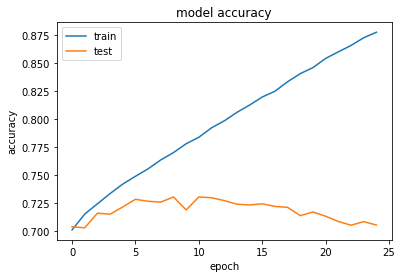

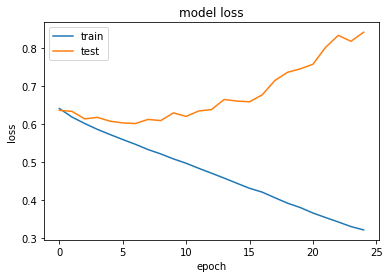

In [30]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

'very bad'